In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

from collections import deque

In [176]:
# Implementation of the WEISS 1997 PCR coalescent model
# https://academic.oup.com/nar/article/25/15/3082/2902152/

C = 20 # num PCR cycles
p = 0.6 # PCR efficiency: change with time later
family_size = 10
num_simulations = 500

max_error = 20
error_distribution = np.zeros(max_error)

for i in np.arange(num_simulations):
    s = forward_sample_tree(C, p)
    tree, n, l, r = coalescent_process(C)
    tree, num_errors, error_locs, error_dict = add_mutations(tree, n, pcr_error_rate=1e-3)
    PCR_error_counts, error_counts_per_reads = count_errors(tree, num_errors)
    
    # assuming errors only occur once per molecule, len will suffice
    # print(PCR_error_counts)
    error_distribution[sum(PCR_error_counts.values())] += 1

[437.  52.   7.   2.   1.   1.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.]
[0.874 0.104 0.014 0.004 0.002 0.002 0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]


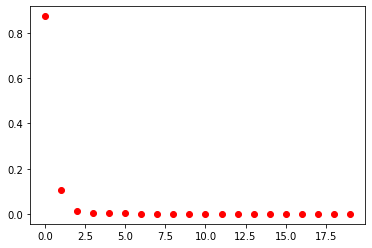

In [178]:
print(error_distribution)
print(error_distribution / num_simulations)
plt.plot(np.arange(max_error), error_distribution / num_simulations, 'ro')

In [153]:
sum(PCR_error_counts.values())

2

In [179]:
def forward_sample_tree(num_pcr_cycles, pcr_efficiency):
    s = np.zeros(num_pcr_cycles+1)
    s[0] = 1 # start with one molecule
    for i in np.arange(num_pcr_cycles):
        s[i+1] = s[i] + np.random.binomial(s[i], pcr_efficiency)
    return s

In [82]:
class Node:
    def __init__(self, cycle, index, leaf = False):
        self.cycle = cycle
        self.index = index
        self.leaf = leaf
        self.newly_synthesized = False
        self.coalescent_as = []
        self.children = []
        self.parent = None
        # error is a triple (source_cycle, source_idx, type)
        self.errors = []

        if leaf:
            self.left = -1
            self.right = -1
        self.mutation = []
    
    def get_cycle(self):
        return self.cycle

    def get_errors(self):
        return self.errors
    
    def get_error_cycle(self, err_num):
        assert err_num < len(self.errors)
        return self.errors[err_num][0]
    
    def get_error_idx(self, err_num):
        assert err_num < len(self.errors)
        return self.errors[err_num][1]
    
    def get_error_type(self, err_num):
        assert err_num < len(self.errors)
        return self.errors[err_num][2]
    
    def get_index(self):
        return self.index
    
    def set_newly_synthesized(self):
        self.newly_synthesized = True
    
    def set_parent(self, node):
        self.parent = node
    
    def get_parent(self):
        return self.parent
    
    def add_child(self, node):
        self.children.append(node)
        
    def get_children(self):
        return self.children
    
    def set_coalescent_as(self, role):
        self.coalescent_as.append(role)
    
    def get_coalescent(self):
        return self.coalescent_as

    def set_error(self, source_cycle, source_idx, source=False):
        if self.cycle == C:
            self.errors.append((source_cycle, source_idx, "source" if source else "inherited"))
            return

        else:   
            if source:
                assert source_cycle == self.get_cycle(), "source_cycle = " + str(source_cycle) + ", cycle = " + str(self.get_cycle())
                assert source_idx == self.get_index(), "source_idx = " + str(source_idx) + ", index = " + str(self.get_index())
                self.errors.append((source_cycle, source_idx, "source"))
                for child in self.get_children():
                    child.set_error(source_cycle, source_idx)
            else:
                assert source_cycle < self.get_cycle(), "source_cycle = " + str(source_cycle) + ", cycle = " + str(self.get_cycle()) 
                self.errors.append((source_cycle, source_idx, "inherited"))
                for child in self.get_children():
                    child.set_error(source_cycle, source_idx)
    
    # Eventually want an error class or at least type synonyms
    
    def print_error(self):
        for error in self.errors:
            print("source cycle = " + str(error[0]) + ", source index = " + str(error[1]) + ", type = " + str(error[2]))

In [162]:
### COALESCENT PROCESS ###
def coalescent_process(C):
    # trace the genealogy of n duplicate reads
    n = np.zeros(C+1) # number of ancestors of observed reads at cycle i
    r = np.zeros(C+1) # number of newly synthesized ancestors of observed reads at cycle i
    l = np.zeros(C+1) # number of coalescent events at cycle i
    
    n[-1] = family_size
    tree = deque()
    tree.appendleft([ Node(cycle=C, index=j, leaf=True) for j in np.arange(family_size) ])

    for i in np.arange(C)[::-1] + 1:
        # sample the number of newly synthesized molecules within the sampled population
        r[i] = np.random.hypergeometric(s[i] - s[i-1], s[i-1], n[i]) # hypergeometric(good balls, bad balls, num draws)
        if r[i] == 0:
            # print("No new molecules sampled at cycle" + str(i))
            # no newly synthesized moelcules among the sampled molecules, so no coalescent
            l[i] = 0
            n[i-1] = n[i]

            nodes_i = tree.popleft()
            nodes_i_minus_1 = [ Node(cycle=i-1, index=j) for j in np.arange(n[i-1]) ]

            for idx in np.arange(n[i-1], dtype=int):
                nodes_i_minus_1[idx].add_child(nodes_i[idx])

            tree.appendleft(nodes_i)
            tree.appendleft(nodes_i_minus_1)
            continue
        # sample the number of coalescents at cycle i
        l[i] = np.random.hypergeometric(n[i]-r[i], s[i-1] - (n[i]-r[i]), r[i])
        n[i-1] = n[i] - l[i]

        # pop nodes at cycle i and create them for the previous generation i-1
        nodes_i = tree.popleft()
        nodes_i_minus_1 = [ Node(cycle=i-1, index=j) for j in np.arange(n[i-1]) ]

        # assign newly synthesized molecules
        newly_synthesized_indices = np.random.choice(np.arange(len(nodes_i)), replace=False, size=int(r[i]))
        existing_molecule_indices = np.setdiff1d(np.arange(len(nodes_i)), newly_synthesized_indices)

        for idx in newly_synthesized_indices:
            nodes_i[idx].set_newly_synthesized()

        # choose a pairs of newly synthesized and exisiting molecules that originate from the same existing molecule
        coalescing_exisiting_indices = np.random.choice(newly_synthesized_indices, replace=False, size=int(l[i]))
        coalescing_newly_synthesized_indices = np.random.choice(existing_molecule_indices, replace=False, size=int(l[i]))

        # choose parents randomly from the i-1th generation
        parents_of_coalescing_nodes_indices = np.random.choice(np.arange(n[i-1]), replace=False, size=int(l[i]))

        non_coalescing_node_indices_i = np.setdiff1d(np.arange(len(nodes_i)), np.union1d(coalescing_exisiting_indices, coalescing_newly_synthesized_indices))
        non_coalescing_node_indices_i_minus_1 = np.setdiff1d(np.arange(len(nodes_i_minus_1)), parents_of_coalescing_nodes_indices)
        assert len(non_coalescing_node_indices_i) == len(non_coalescing_node_indices_i_minus_1)

        for (parent_idx, new_idx, existing_idx) in zip(parents_of_coalescing_nodes_indices, coalescing_exisiting_indices,coalescing_newly_synthesized_indices):
            nodes_i_minus_1[int(parent_idx)].add_child(nodes_i[int(new_idx)])
            nodes_i_minus_1[int(parent_idx)].add_child(nodes_i[int(existing_idx)])

            nodes_i_minus_1[int(parent_idx)].set_coalescent_as("parent")
            nodes_i[int(new_idx)].set_coalescent_as("child")
            nodes_i[int(existing_idx)].set_coalescent_as("child")

        # randomly pair up the remaining nodes
        for parent_idx, child_idx in zip(non_coalescing_node_indices_i_minus_1, non_coalescing_node_indices_i):
            nodes_i_minus_1[int(parent_idx)].add_child(nodes_i[int(child_idx)])

        tree.appendleft(nodes_i)
        tree.appendleft(nodes_i_minus_1)
    return tree, n, l, r

In [111]:
### Helper Methods ###
def remove_errors():
    for nodes in tree:
        for node in nodes:
            node.errors = []
            
def print_tree():
    for i, nodes in enumerate(tree):
        print("cycle = " + str(i))
        print("num nodes = " + str(len(nodes)))
        for node in nodes:
            print("index = " + str(node.index) + ", children = " + str([(c.get_cycle(), c.get_index()) for c in node.get_children()]) + ", coalescent = " + str(node.get_coalescent()))
            node.print_error()

In [165]:
def add_mutations(tree, n, pcr_error_rate=1e-2):
    u = pcr_error_rate # per generation PCR error rate, in the units of mutations per generation
    error_locs = []
    error_dict = {}
    num_errors = 0
    for cycle in np.arange(C):
        num_edges = n[cycle+1]
        errors = np.random.poisson(u, int(num_edges))
        error_dict[cycle+1] = errors
        if np.sum(errors) > 0:
            num_errors += np.count_nonzero(errors)
            for err_node_idx in np.argwhere(errors).flatten():
                list(tree)[cycle+1][err_node_idx].set_error(cycle+1, err_node_idx, True)
                error_locs.append((cycle+1, err_node_idx))
    assert num_errors == len(error_locs)
    return tree, num_errors, error_locs, error_dict

In [140]:
def count_errors(tree, num_errors): 
    reads = list(tree)[-1]

    PCR_error_counts = {}
    for read in reads:
        errors = read.get_errors()
        if len(errors) == 0:
            continue
        for error in errors:
            if error in PCR_error_counts:
                PCR_error_counts[error] += 1
            else:
                PCR_error_counts[error] = 1

    # counts must be less than 10...
    assert len(PCR_error_counts) == num_errors
    error_counts_per_reads = [ len(r.get_errors()) for r in reads ]
    return PCR_error_counts, error_counts_per_reads